In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install PyWavelets

#Toeplitz convolution

✅ Shape của X_filtered: (5000, 140)
✅ Số nhãn y_filtered: 5000

✅ Test ratio r = 0.90 (Chia lần thử: 1)
📊 Phân bố lớp trong test set: {np.int64(0): np.int64(2627), np.int64(1): np.int64(1873)}
[[2606   21]
 [   9 1864]]
              precision    recall  f1-score   support

      Normal      0.997     0.992     0.994      2627
     Anomaly      0.989     0.995     0.992      1873

    accuracy                          0.993      4500
   macro avg      0.993     0.994     0.993      4500
weighted avg      0.993     0.993     0.993      4500

🎯 Accuracy: 0.993
📌 Precision: 0.989
📌 Recall: 0.995
📌 F1-score: 0.992
🏁 AUC: 1.000


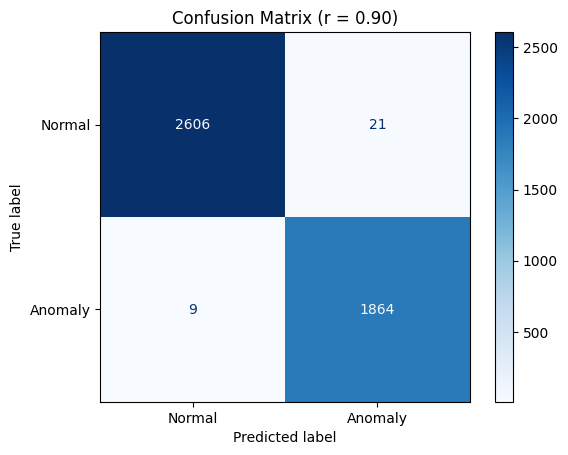

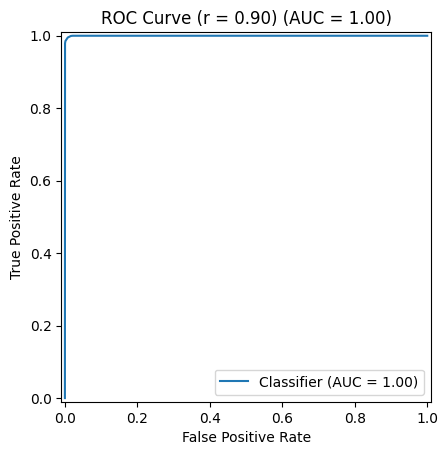


⏱️ Tổng thời gian chạy từ tiền xử lý đến đánh giá: 145.76 giây


In [ ]:
import numpy as np
import pywt
from scipy.signal import iirnotch, medfilt, butter, filtfilt, convolve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import time

# Bắt đầu đo thời gian bắt đầu chạy -> kết thúc
start_pipeline = time.time()

# --- 1. Đọc file .ts ---
def load_ts_file(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    data_started = False
    data, labels = [], []
    for line in lines:
        line = line.strip()
        if line == "" or line.startswith("@"):
            if line.lower().startswith("@data"):
                data_started = True
            continue
        if data_started:
            parts = line.split(":")
            series = [float(x) for x in parts[0].split(",")]
            label = int(parts[1])
            data.append(series)
            labels.append(label)
    return np.array(data), np.array(labels)

# --- 6. Định nghĩa các hàm xử lý tín hiệu ---
# 1. Notch filter
def apply_notch_filter(x, f0=50.0, Q=30.0, fs=1000):
    b, a = iirnotch(f0, Q, fs)
    return filtfilt(b, a, x)

# 2. Median filter
def apply_median_filter(x, kernel_size=3):
    return medfilt(x, kernel_size=kernel_size)

# 3. Wavelet denoise
def wavelet_denoise(x, wavelet='db4', level=4, threshold=0.05):
    coeffs = pywt.wavedec(x, wavelet, level=level)
    coeffs_thresh = [coeffs[0]]  # giữ nguyên cA
    for detail in coeffs[1:]:
        coeffs_thresh.append(pywt.threshold(detail, threshold, mode='soft'))
    return pywt.waverec(coeffs_thresh, wavelet)[:len(x)]


# 4. Baseline drift removal
def remove_baseline(x):
    return x - np.mean(x)

# 5. MSE và PSNR
def compute_mse_psnr(x_orig, x_clean):
    mse = np.mean((x_orig - x_clean)**2)
    mse = max(mse, 1e-10)  # Đảm bảo MSE không bằng 0
    psnr = 20 * np.log10(np.max(x_orig) / np.sqrt(mse))
    return mse, psnr




# Luôn xử lý lại cho đến khi đạt yêu cầu MSE & PSNR
def process_until_pass(xi, mse_thresh=0.03, psnr_thresh=30):
    while True:
        x1 = apply_notch_filter(xi)
        x2 = apply_median_filter(x1)
        x3 = wavelet_denoise(x2)
        x4 = remove_baseline(x3)

        mse, psnr = compute_mse_psnr(xi, x4);
        # print(f"MSE: {mse:.6f}");
        # print(f"PSNR: {psnr:.2f} dB");
        if mse < mse_thresh and psnr > psnr_thresh:
            return x4  # chỉ dừng khi đạt yêu cầu
        else:
          xi = x4



def preprocess_and_filter_all(X, y, mse_thresh=0.03, psnr_thresh=30):
    X_processed, y_processed = [], []
    for xi, yi in zip(X, y):
        x_clean = process_until_pass(xi, mse_thresh, psnr_thresh)
        X_processed.append(x_clean)
        y_processed.append(yi)
    return np.array(X_processed), np.array(y_processed)

# --- 3: Toeplitz construction ---
def construct_toeplitz(X):
    n, s = X.shape
    T = np.zeros((2 * n - 1, s + 2))
    for i in range(n):
        mu = np.mean(X[i])
        sigma = np.std(X[i])
        kernel = np.array([mu - 2 * sigma, mu, mu + 2 * sigma])
        for j in range(s):
            row_slice = slice(i, i + n)
            col_slice = slice(j, j + 3)
            if row_slice.stop <= 2 * n - 1 and col_slice.stop <= s + 2:
                T[row_slice, col_slice] += X[i, j] * kernel
    return T

def construct_c(T, n, s):
    C = np.zeros((n, s))
    for i in range(n):
        for j in range(s):
            C[i, j] = np.sum(T[i:i+n, j:j+3])
    return C

def pooling(C):
    return 0.5 * (C[:, :-1:2] + C[:, 1::2])

def adaptive_toeplitz_convolution(X_prep):
    T = construct_toeplitz(X_prep)
    C = construct_c(T, X_prep.shape[0], X_prep.shape[1])
    X_pool = pooling(C)
    return X_pool

# --- 4. Định nghĩa các hàm xử lý phân loại ---
def standardize(X_train, X_test):
    scaler = StandardScaler()
    return scaler.fit_transform(X_train), scaler.transform(X_test)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, auc

# Hàm mở rộng từ code trước của bạn – vẽ confusion matrix và ROC-AUC
def plot_confusion_and_auc(y_true, y_pred, y_score, title_suffix=""):
    # 1. Ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix {title_suffix}")
    plt.grid(False)
    plt.show()

    # 2. AUC - ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Classifier').plot()
    plt.title(f"ROC Curve {title_suffix} (AUC = {roc_auc:.2f})")
    plt.show()


def train_and_evaluate_knn(X, y, r=0.9, max_attempts=10):

    # 👉 Chia train/test đến khi test set có đủ nhãn
    for attempt in range(max_attempts):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=r, stratify=y, random_state=42 + attempt)
        unique_labels = np.unique(y_test)
        if len(unique_labels) == 2:
            break
    else:
        print("❌ Không thể tạo tập test có đủ 2 nhãn sau nhiều lần thử.")
        return None  # để rõ ràng hơn

    # 👉 Chuẩn hóa
    X_train_scaled, X_test_scaled = standardize(X_train, X_test)

    # 👉 Huấn luyện KNN
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train_scaled, y_train)

    # 👉 Dự đoán và tính AUC
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # 👉 In kết quả
    print(f"\n✅ Test ratio r = {r:.2f} (Chia lần thử: {attempt+1})")
    print("📊 Phân bố lớp trong test set:", dict(zip(*np.unique(y_test, return_counts=True))))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=3, target_names=["Normal", "Anomaly"]))
    print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"📌 Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"📌 Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"📌 F1-score: {f1_score(y_test, y_pred):.3f}")
    print(f"🏁 AUC: {roc_auc_score(y_test, y_prob):.3f}")

    # 👉 VẼ biểu đồ confusion matrix và AUC
    plot_confusion_and_auc(y_test, y_pred, y_prob, title_suffix=f"(r = {r:.2f})")

# --- 5. Gọi lại các hàm để thực nghiệm ---
# Load dữ liệu từ .ts
X_train_raw, y_train_raw = load_ts_file("/content/drive/MyDrive/Colab Notebooks/Dataset/ECG5000_TRAIN.ts")
X_test_raw, y_test_raw = load_ts_file("/content/drive/MyDrive/Colab Notebooks/Dataset/ECG5000_TEST.ts")
# X_train_raw, y_train_raw = load_ts_file("/content/drive/MyDrive/IS405_DLL/Đồ án DLL/ecg50000/ECG5000_TRAIN.ts")
# X_test_raw, y_test_raw = load_ts_file("/content/drive/MyDrive/IS405_DLL/Đồ án DLL/ecg50000/ECG5000_TEST.ts")

# Chuyển nhãn: 1 → Normal (0), còn lại → Anomaly (1)
y_train = np.where(y_train_raw == 1, 0, 1)
y_test = np.where(y_test_raw == 1, 0, 1)

# Gộp tập train + test
X_all = np.concatenate([X_train_raw, X_test_raw])
y_all = np.concatenate([y_train, y_test])

# Lọc dữ liệu
X_filtered, y_filtered = preprocess_and_filter_all(X_all, y_all, mse_thresh=0.03, psnr_thresh=30)

print("✅ Shape của X_filtered:", X_filtered.shape)
print("✅ Số nhãn y_filtered:", len(y_filtered))

# Trích xuất đặc trưng bằng Toeplitz Convolution
X_feat = adaptive_toeplitz_convolution(X_filtered)
# Huấn luyện và đánh giá KNN
result = train_and_evaluate_knn(X_feat, y_filtered, r=0.9)

# Kết thúc đo thời gian
end_pipeline = time.time()
print(f"\n⏱️ Tổng thời gian chạy từ tiền xử lý đến đánh giá: {end_pipeline - start_pipeline:.2f} giây")